In [1]:
from transformers import TrainingArguments
from trl import SFTTrainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from triviaqa_datasets.datasets import ContextualizedQADatasetForCriticFinetuning
from utils.utils import convert_to_hf_dataset, plot_training_curve
from datasets import *
import os
import json

In [2]:
dataset="triviaqa"
model_path="/home/users/nus/e1101650/scratch/llama2-chat-hf-cache/models--meta-llama--Llama-2-7b-chat-hf/snapshots/09bd0f49e16738cdfaa6e615203e126038736eb0"
data_path="triviaqa_datasets/TriviaQA/rc/qa/bootstrap/web_train_evaluation_generation.json"
save_data_path="triviaqa_datasets"
save_model_path="finetuned_models"
batch_size = 16

In [3]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import torch

tokenizer = AutoTokenizer.from_pretrained(model_path)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=bnb_config,
    # device_map=args.device,
    device_map="auto",
    local_files_only = True
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def finetune_with_triviaqa(model, tokenizer, dataset, data_path, output_data_dir, output_model_dir):
    '''
    Load Q,D,R,E dataset from web_train_evaluation_generation.json
    '''
    print("Loading dataset...\n")
    hf_dataset_path = os.path.join(output_data_dir, "triviaqa_datasets_hf")

    if not os.path.exists(hf_dataset_path):
        triviaQA = ContextualizedQADatasetForCriticFinetuning.from_dataset(dataset=dataset, data_path=data_path)

        print("Convert to huggingface dataset...\n")
        triviaQA_hf = convert_to_hf_dataset(triviaQA)

        # Train-val split
        triviaQA_hf.save_to_disk(os.path.join(output_data_dir, "triviaqa_datasets_hf"))

        # Train val 90-10
        triviaQA_hf_split = triviaQA_hf.train_test_split(test_size=0.1, shuffle=False)    
        triviaQA_hf_split["train"].save_to_disk(os.path.join(output_data_dir, "triviaqa_datasets_hf_train"))
        triviaQA_hf_split["test"].save_to_disk(os.path.join(output_data_dir, "triviaqa_datasets_hf_val"))

    dset_train = load_from_disk(os.path.join(output_data_dir, "triviaqa_datasets_hf_train"))
    dset_val = load_from_disk(os.path.join(output_data_dir, "triviaqa_datasets_hf_val"))
    
    print("Loaded dataset successfully!\n")


In [5]:
finetune_with_triviaqa(model, tokenizer, dataset, data_path, save_data_path, save_model_path)

Loading dataset...

Loaded dataset successfully!



In [6]:
from datasets import load_from_disk
import os
import torch
import transformers
from  langchain import LLMChain, HuggingFacePipeline, PromptTemplate
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import os
from torch.utils.data import Dataset

dset_train = load_from_disk(os.path.join(save_data_path , "triviaqa_datasets_hf_train"))
dset_val = load_from_disk(os.path.join(save_data_path , "triviaqa_datasets_hf_val"))

# Train

In [12]:
len(dset_train)

25005

In [13]:
# Setting config.pretraining_tp to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits.
model.config.pretraining_tp = 1
tokenizer.pad_token = tokenizer.eos_token

In [14]:
def format_prompt(sample):
    return f"""
{sample["qrd"]}
{sample["e"]}
"""

In [15]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
# These parameters are double of parameters used in Radiology-Llama2
# Alpha is twice the rank value usually
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.1,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
)
# Prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [16]:
batch_size

16

In [17]:
from transformers import TrainingArguments


args = TrainingArguments(
    output_dir=save_model_path,
    num_train_epochs=1,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=10,
    save_strategy="steps",
    save_steps=50,
    evaluation_strategy="steps", # Evaluate the model every logging step
    eval_steps=50,               # Evaluate and save checkpoints every 50 steps 
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=False
)

In [18]:
# PEFT parameters
lora_alpha=32
lora_dropout=0.1
r=16
bias="none"
task_type="CAUSAL_LM"

# SFTT parameters
num_train_epochs=1
gradient_accumulation_steps=2
optim="paged_adamw_32bit"
logging_steps=10
save_strategy="steps"
evaluation_strategy="steps"
eval_steps=10
do_eval=True
learning_rate=2e-4
max_grad_norm=0.3
warmup_ratio=0.03
lr_scheduler_type="constant"


# Train

In [19]:
from trl import SFTTrainer

max_seq_length = 1024 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dset_train,
    eval_dataset=dset_val,
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=True,
    max_seq_length  = max_seq_length,
    formatting_func=format_prompt,
    args=args,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
# Train
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,1.435800,1.392341
100,1.361700,1.350433
150,1.351100,1.339415
200,1.328800,1.333122
250,1.353500,1.328134
300,1.344300,1.324156
350,1.299100,1.321285
400,1.353400,1.318686
450,1.304900,1.315897


/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /home/users/nus/e1101650/scratch/llama2-chat-hf-cache/models--meta-llama--Llama-2-7b-chat-hf/snapshots/09bd0f49e16738cdfaa6e615203e126038736eb0 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find

In [20]:
# Train
trainer.train(resume_from_checkpoint=True)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
500,1.318000,1.313264
550,1.322700,1.311806
600,1.290400,1.309776
650,1.314600,1.308110
700,1.282300,1.305972


/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /home/users/nus/e1101650/scratch/llama2-chat-hf-cache/models--meta-llama--Llama-2-7b-chat-hf/snapshots/09bd0f49e16738cdfaa6e615203e126038736eb0 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/users/nus/e1101650/.conda/envs/rag-critic2/lib/python3.12/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find

TrainOutput(global_step=728, training_loss=0.5016333297058776, metrics={'train_runtime': 4528.3159, 'train_samples_per_second': 5.146, 'train_steps_per_second': 0.161, 'total_flos': 9.469138814380278e+17, 'train_loss': 0.5016333297058776, 'epoch': 1.0})

# Plot training loss

In [21]:
import json
with open("finetuned_models/checkpoint-700/trainer_state.json","r") as file:
    training_logs = json.load(file)

In [35]:
# len(training_logs["log_history"]) #84 because 70 training and 14 for eval

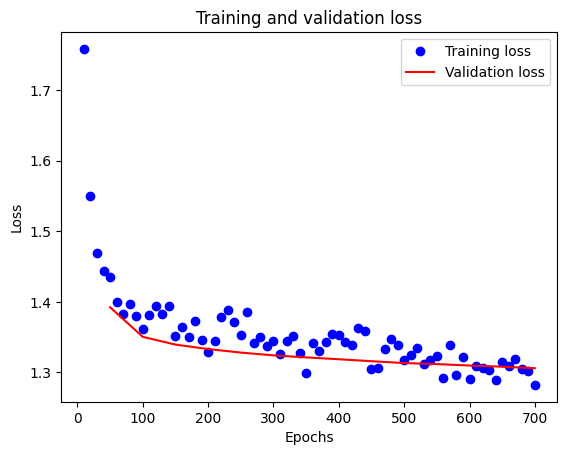

In [48]:
# Extract training and validation loss
import matplotlib.pyplot as plt

data = training_logs["log_history"]
train_loss = [entry['loss'] for entry in data if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]

# Plotting
epochs = range(10, len(train_loss)*10 + 10, 10)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
val_epochs = range(50,len(train_loss)*10 + 10,50)
plt.plot(val_epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load model

In [49]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import torch

In [52]:
critic_model_path="finetuned_models/checkpoint-700"
tokenizer = AutoTokenizer.from_pretrained(critic_model_path)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)
model = AutoModelForCausalLM.from_pretrained(
    critic_model_path,
    quantization_config=bnb_config,
    # device_map=args.device,
    device_map="auto",
    local_files_only = True
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]